<a href="https://colab.research.google.com/github/bala-baskar/aiml_tech_courses/blob/main/pytorch/02_neural_network_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [148]:
import torch
from torch import nn

### **Create dataset**

In [149]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

print(len(X),len(y))

1000 1000


In [150]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [151]:
import pandas as pd

circles = pd.DataFrame({"X1":X[:,0], "X2":X[:,1], "label":y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


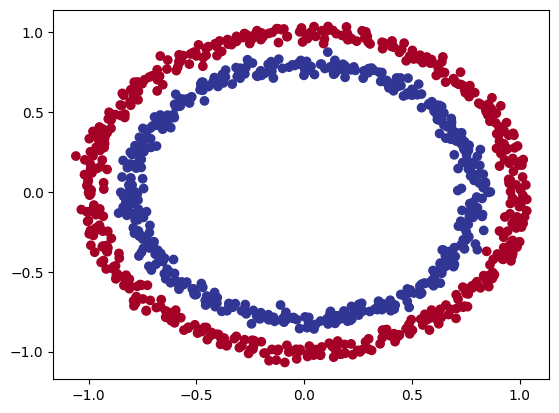

In [152]:
import matplotlib.pyplot as plt
plt.scatter(x='X1',y='X2',c='label',data=circles,cmap=plt.cm.RdYlBu)

In [153]:
print(X.shape, y.shape)

(1000, 2) (1000,)


In [154]:
# convert to tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
print(type(X), X.dtype, y.dtype)

torch.manual_seed(42)

<class 'torch.Tensor'> torch.float32 torch.float32


In [155]:
# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([800, 2]) torch.Size([200, 2]) torch.Size([800]) torch.Size([200])


### **Build model**

In [156]:
# Build a model
import torch
from torch import nn

# Make device agnostic code
device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [157]:
class CircleModelV0(nn.Module):

  def __init__(self):
    super().__init__()
    self.linear_layer_1 = nn.Linear(in_features = 2,
                                  out_features = 5)
    self.linear_layer_2 = nn.Linear(in_features = 5,
                                  out_features = 1)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.linear_layer_2(self.linear_layer_1(x)) # x -> layer_1 -> layer_2 -> output

In [158]:
model_0 = CircleModelV0().to(device)
print(model_0)
print(model_0.state_dict())

CircleModelV0(
  (linear_layer_1): Linear(in_features=2, out_features=5, bias=True)
  (linear_layer_2): Linear(in_features=5, out_features=1, bias=True)
)
OrderedDict([('linear_layer_1.weight', tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427],
        [-0.3443,  0.4153],
        [ 0.6233, -0.5188]])), ('linear_layer_1.bias', tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410])), ('linear_layer_2.weight', tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]])), ('linear_layer_2.bias', tensor([-0.2060]))])


In [159]:
# Using nn.Sequential
model_1 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    nn.Linear(in_features = 5, out_features = 1)
              ).to(device)
print(model_1)
print(model_1.state_dict())

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)
OrderedDict([('0.weight', tensor([[-0.0829, -0.2872],
        [ 0.4691, -0.5582],
        [-0.3260, -0.1997],
        [-0.4252,  0.0667],
        [-0.6984,  0.6386]])), ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])), ('1.weight', tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])), ('1.bias', tensor([-0.1213]))])


### **Loss function & Optimizer**

In [160]:
# Setup the loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss() # nn.Sequential (nn.Sigmoid(), nn.BCELoss())
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr= 0.1)

In [161]:
# Calculate accuracy
def accuracy_fn(y_actual, y_pred):
  correct = torch.eq(y_actual,y_pred).sum().item()
  acc = (correct/len(y_actual)) * 100
  return acc

### **Train the model**

In [162]:
# Train the model
epochs = 100
epoch_vals= []
loss_vals = []
test_loss_vals = []
test_acc_vals = []

for epoch in range(epochs):
  # 1. Initiate model train
  model_1.train()
  # 2. Forward pass
  y_logits = model_1(X_train).squeeze() # forward function gives logit values
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labels, round as cutoff threshold
  # 3. Calculate loss & accuracy
  loss= loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_train,y_pred)
  # 4. Optimizer zero grad
  optimizer.zero_grad()
  # 5. Backpropagation
  loss.backward()
  # 6. gradient descent
  optimizer.step()
  # 7. Testing
  model_1.eval()
  with torch.inference_mode():
    y_logits_n = model_1(X_test).squeeze()
    y_pred_n = torch.round(torch.sigmoid(y_logits_n))
    test_loss = loss_fn(y_pred_n,y_test)
    test_acc = accuracy_fn(y_test,y_pred_n)

  if epoch % 10 == 0:
    print(f"Epoch {epoch} - Loss {loss} - Testloss {test_loss} - Accuracy {test_acc}")
    epoch_vals.append(epoch)
    loss_vals.append(loss)
    test_loss_vals.append(test_loss)
    test_acc_vals.append(test_acc)

Epoch 0 - Loss 0.6979604959487915 - Testloss 0.740830659866333 - Accuracy 57.99999999999999
Epoch 10 - Loss 0.6958984136581421 - Testloss 0.757422685623169 - Accuracy 53.0
Epoch 20 - Loss 0.6949015855789185 - Testloss 0.7635118365287781 - Accuracy 49.5
Epoch 30 - Loss 0.6943498253822327 - Testloss 0.7599084377288818 - Accuracy 49.5
Epoch 40 - Loss 0.6940091848373413 - Testloss 0.7506067156791687 - Accuracy 51.0
Epoch 50 - Loss 0.6937822103500366 - Testloss 0.7544054985046387 - Accuracy 50.0
Epoch 60 - Loss 0.6936231255531311 - Testloss 0.7451038360595703 - Accuracy 51.5
Epoch 70 - Loss 0.6935079097747803 - Testloss 0.7482044100761414 - Accuracy 51.0
Epoch 80 - Loss 0.693422257900238 - Testloss 0.7544056177139282 - Accuracy 50.0
Epoch 90 - Loss 0.6933572888374329 - Testloss 0.7394055724143982 - Accuracy 53.0


### **Visualize the decision boundary**

In [163]:
# Plot decision boundary

from pathlib import Path
import requests

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping the download")
else:
  print("Downloading the helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)
    f.close()

helper_functions.py already exists, skipping the download


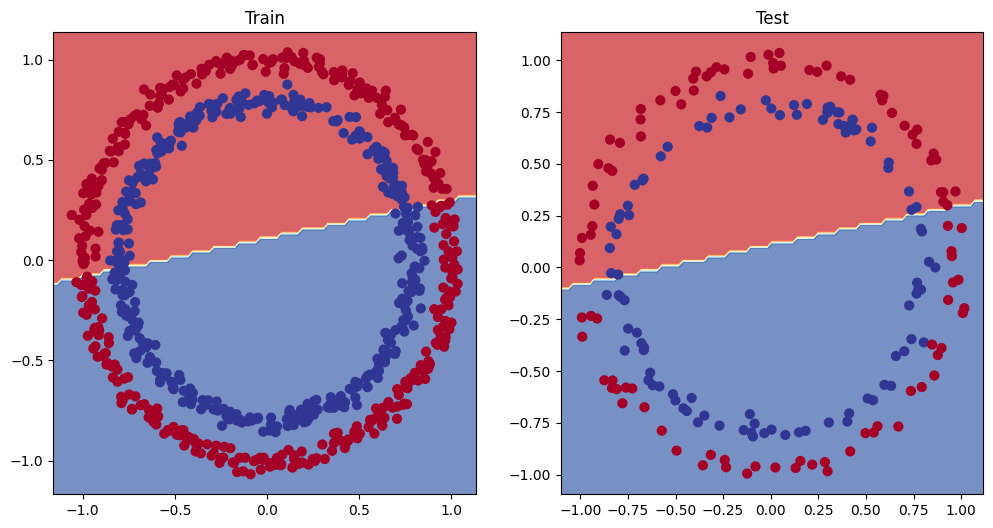

In [164]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test,y_test)

### **Improve the model**

Following are the ways to improve the deep learning model
1. Adding layers
2. Increase the number of hidden units
3. Change/ Add activation functions
4. Change the optimization function
5. Change the learning rate
6. Change the loss function
7. Fitting for longer

In [165]:
class CircleModelV1(nn.Module):

  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=100)
    self.layer_2 = nn.Linear(in_features=100,out_features=70)
    self.layer_3 = nn.Linear(in_features=70,out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    #z = self.layer_1(x)
    #z = self.layer_2(z)
    #z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x)))

In [166]:
model_2 = CircleModelV1().to(device)
print(model_2)

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=70, bias=True)
  (layer_3): Linear(in_features=70, out_features=1, bias=True)
)


In [167]:
# Setup the loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss() # nn.Sequential (nn.Sigmoid(), nn.BCELoss())
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr= 0.1)

In [168]:
torch.manual_seed(123)
torch.cuda.manual_seed(123)
epochs = 1000

for epoch in range(epochs):

  model_2.train()
  y_logits = model_2(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits,y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model_2.eval()
  with torch.inference_mode():
    y_logits_n = model_2(X_test).squeeze()
    y_preds_n = torch.round(torch.sigmoid(y_logits_n))
    test_loss = loss_fn(y_logits_n,y_test)
    test_acc = accuracy_fn(y_test,y_pred_n)

  if epoch % 100 == 0:
    print(f"Epoch {epoch} - Loss {loss} - Testloss {test_loss} - Accuracy {test_acc}")

Epoch 0 - Loss 0.7001819014549255 - Testloss 0.6988087296485901 - Accuracy 53.0
Epoch 100 - Loss 0.7001819014549255 - Testloss 0.6988087296485901 - Accuracy 53.0
Epoch 200 - Loss 0.7001819014549255 - Testloss 0.6988087296485901 - Accuracy 53.0
Epoch 300 - Loss 0.7001819014549255 - Testloss 0.6988087296485901 - Accuracy 53.0
Epoch 400 - Loss 0.7001819014549255 - Testloss 0.6988087296485901 - Accuracy 53.0
Epoch 500 - Loss 0.7001819014549255 - Testloss 0.6988087296485901 - Accuracy 53.0
Epoch 600 - Loss 0.7001819014549255 - Testloss 0.6988087296485901 - Accuracy 53.0
Epoch 700 - Loss 0.7001819014549255 - Testloss 0.6988087296485901 - Accuracy 53.0
Epoch 800 - Loss 0.7001819014549255 - Testloss 0.6988087296485901 - Accuracy 53.0
Epoch 900 - Loss 0.7001819014549255 - Testloss 0.6988087296485901 - Accuracy 53.0


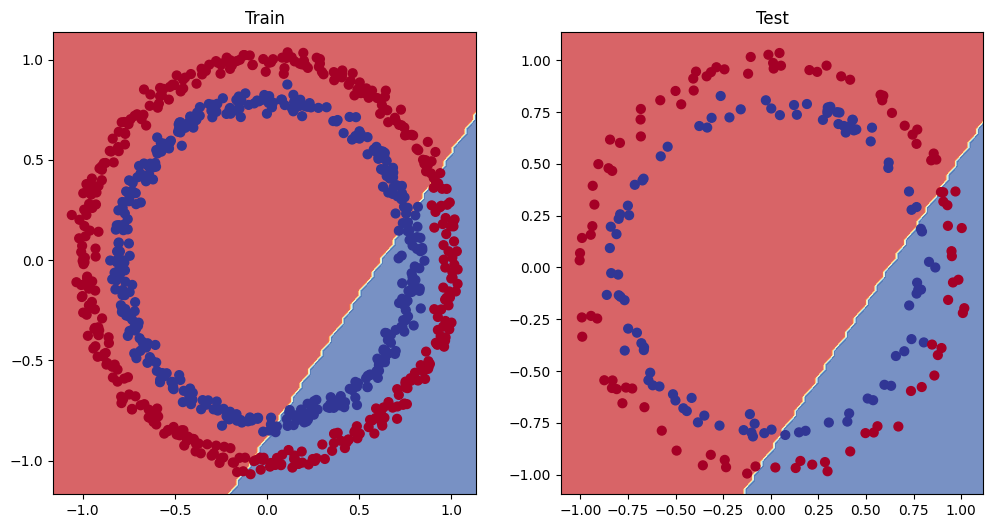

In [169]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2,X_test,y_test)

### **Improve using Non-linear function**

In [182]:
class CircleModelV2(nn.Module):

  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)
    self.relu = nn.ReLU()

  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [183]:
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [184]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_3.parameters(),
                            lr= 0.1)

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([800, 2]) torch.Size([200, 2]) torch.Size([800]) torch.Size([200])


In [186]:
epochs = 1200
torch.manual_seed(123)
torch.cuda.manual_seed(123)

for epoch in range(epochs):
  model_3.train()
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits,y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    y_logits_n = model_3(X_test).squeeze()
    y_pred_n = torch.round(torch.sigmoid(y_logits_n))
    test_loss = loss_fn(y_logits_n,y_test)
    test_acc = accuracy_fn(y_test,y_pred_n)

  if epoch % 100 == 0:
    print(f"Epoch {epoch}: Loss {loss}: Test loss {test_loss}, Accuracy {test_acc}")

Epoch 0: Loss 0.7111436724662781: Test loss 0.7091482281684875, Accuracy 50.0
Epoch 100: Loss 0.6899107098579407: Test loss 0.6888172030448914, Accuracy 53.5
Epoch 200: Loss 0.6882702708244324: Test loss 0.6876319050788879, Accuracy 55.00000000000001
Epoch 300: Loss 0.6863572597503662: Test loss 0.6862717270851135, Accuracy 55.00000000000001
Epoch 400: Loss 0.6838598847389221: Test loss 0.6845590472221375, Accuracy 55.50000000000001
Epoch 500: Loss 0.6803831458091736: Test loss 0.6822090148925781, Accuracy 56.49999999999999
Epoch 600: Loss 0.6752644181251526: Test loss 0.6786166429519653, Accuracy 57.49999999999999
Epoch 700: Loss 0.6671649217605591: Test loss 0.6724731922149658, Accuracy 59.5
Epoch 800: Loss 0.6538532972335815: Test loss 0.6616766452789307, Accuracy 66.5
Epoch 900: Loss 0.6302109360694885: Test loss 0.6426228880882263, Accuracy 75.0
Epoch 1000: Loss 0.5835033059120178: Test loss 0.6062103509902954, Accuracy 82.5
Epoch 1100: Loss 0.5063232183456421: Test loss 0.5370762

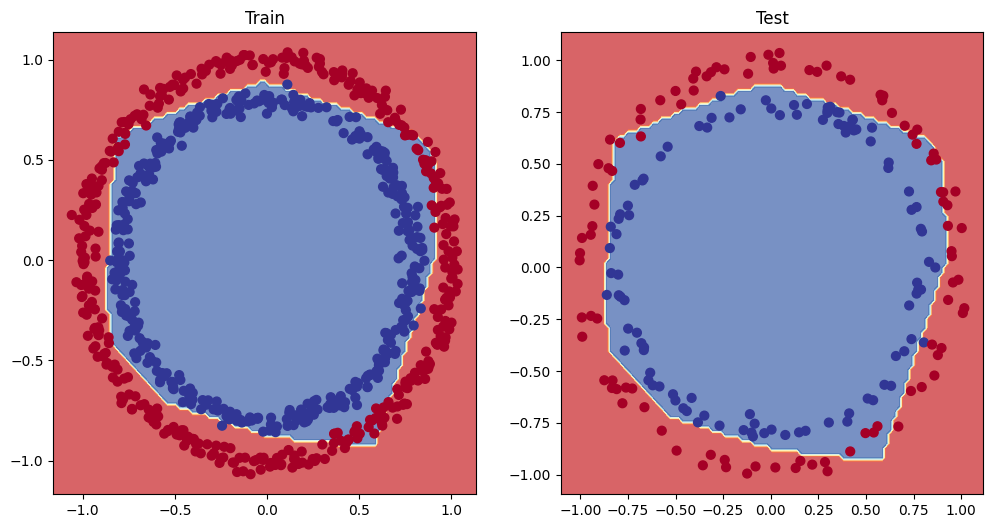

In [187]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3,X_test,y_test)

### **Non-linear activation function**

In [202]:
def relu(x):
  return torch.maximum(torch.tensor(0),x)

def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

In [190]:
x = torch.arange(-10,10)
x

tensor([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,
          4,   5,   6,   7,   8,   9])

In [191]:
relu(x)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Text(0.5, 1.0, 'Sigmoid (x)')

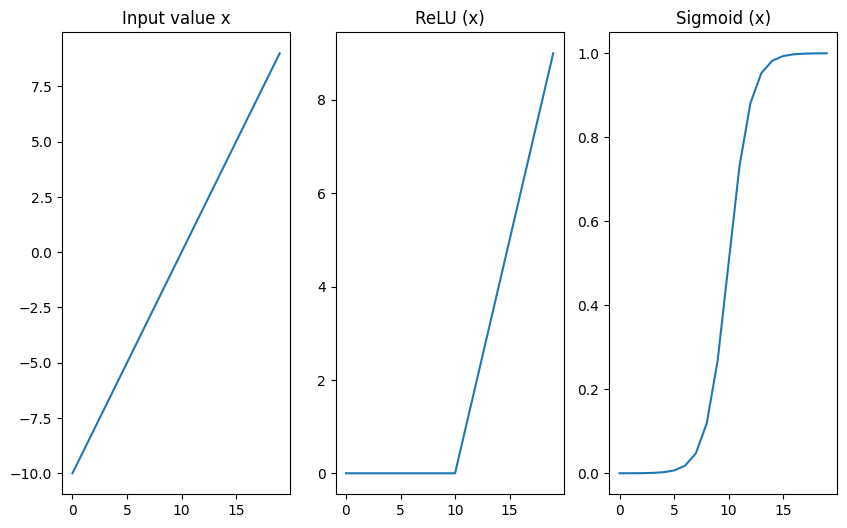

In [203]:
plt.figure(figsize=(10,6))
plt.subplot(1,3,1)
plt.plot(x)
plt.title("Input value x")
plt.subplot(1,3,2)
plt.plot(relu(x))
plt.title("ReLU (x)")
plt.subplot(1,3,3)
plt.plot(sigmoid(x))
plt.title("Sigmoid (x)")

## Multi-Class classification problem

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


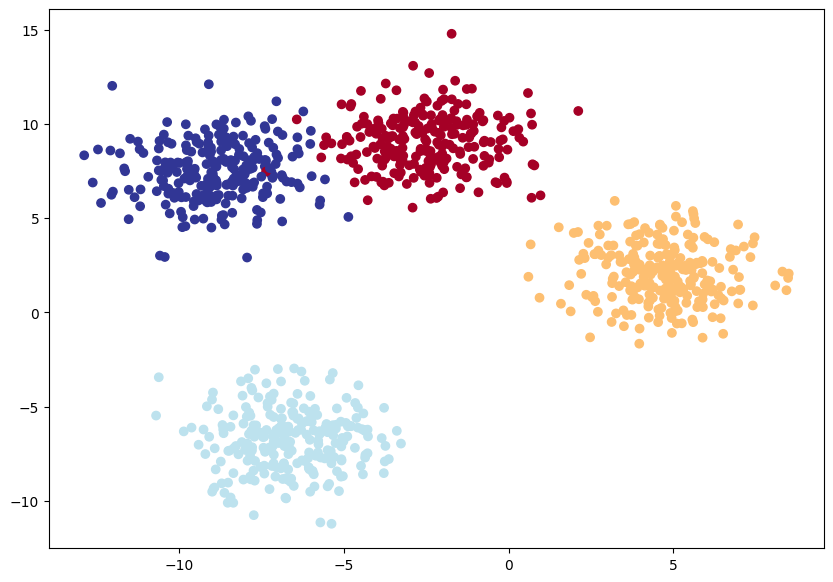

In [204]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [249]:
# Build a model

class BlobModel(nn.Module):

  def __init__(self,input_features,output_features,hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

In [250]:
model_4 = BlobModel(input_features=2,output_features=4,hidden_units=8).to(device)
print(model_4)

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)


In [251]:
# Loss function & Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr= 0.1)

In [252]:
epochs = 1000

for epoch in range(epochs):

  model_4.train()
  y_logits = model_4(X_blob_train)
  y_preds = torch.argmax(torch.softmax(y_logits,dim=1),dim=1)
  loss = loss_fn(y_logits,y_blob_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model_4.eval()
  with torch.inference_mode():
    y_logits_t = model_4(X_blob_test)
    y_preds_t = torch.argmax(torch.softmax(y_logits_t, dim=1),dim=1)
    test_loss = loss_fn(y_logits_t,y_blob_test)
    test_acc = accuracy_fn(y_blob_test,y_preds_t)

  if epoch % 100 == 0:
    print(f"Epoch {epoch}: Loss {loss}: Test loss {test_loss}: Test Accuracy {test_acc}")

Epoch 0: Loss 1.6629307270050049: Test loss 1.284339189529419: Test Accuracy 51.0
Epoch 100: Loss 0.03552795574069023: Test loss 0.02690991200506687: Test Accuracy 99.5
Epoch 200: Loss 0.02792365476489067: Test loss 0.018757589161396027: Test Accuracy 99.5
Epoch 300: Loss 0.025893494486808777: Test loss 0.0162939615547657: Test Accuracy 99.5
Epoch 400: Loss 0.024964025244116783: Test loss 0.014967436902225018: Test Accuracy 99.5
Epoch 500: Loss 0.024366065859794617: Test loss 0.014137517660856247: Test Accuracy 99.5
Epoch 600: Loss 0.023903658613562584: Test loss 0.013520573265850544: Test Accuracy 99.5
Epoch 700: Loss 0.023507464677095413: Test loss 0.013016361743211746: Test Accuracy 99.5
Epoch 800: Loss 0.023152584210038185: Test loss 0.01258681621402502: Test Accuracy 99.5
Epoch 900: Loss 0.022826364263892174: Test loss 0.012209994718432426: Test Accuracy 99.5


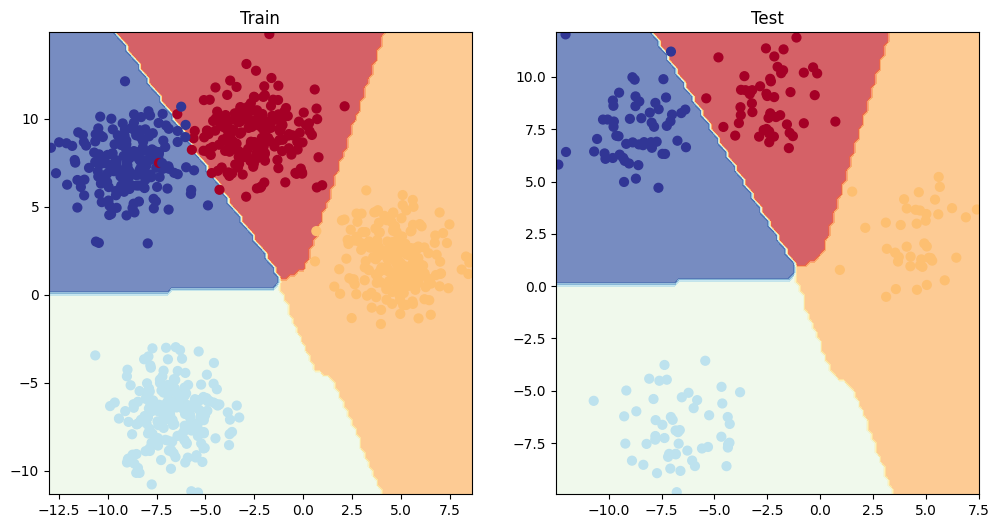

In [253]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4,X_blob_train,y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4,X_blob_test,y_blob_test)

### More metrics

In [254]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 5.6 MB/s eta 0:00:00


In [260]:
from torchmetrics import Accuracy

torch_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

torch_accuracy(y_preds_t,y_blob_test)

tensor(0.9950)